In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue
import seaborn as sns
import random, numpy as np, torch


def set_global_seed(seed):
    # Python RNG
    random.seed(seed)

    # NumPy RNG
    np.random.seed(seed)

    # PyTorch CPU RNG
    torch.manual_seed(seed)

    # PyTorch GPU RNG
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # cuDNN deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Ensures deterministic algorithms wherever possible
    torch.use_deterministic_algorithms(True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-5, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=50000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        # device, not needed, but needed if going on canada compute to specify gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.q_nn = self.build_nn().to(self.device) # build q network
        self.target_net = self.build_nn().to(self.device) # build target network
        self.target_net.load_state_dict(self.q_nn.state_dict()) # make target net same as q net. initialization is random so need this
        self.optimizer = optim.Adam(self.q_nn.parameters(), lr=lr) 
        
    def build_nn(self): # to build the q network, 2 hidden layer with relu and 128 neurons in each
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_dim)
        )
    
    def agent_policy(self, state): # act e greedy
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim) # rand action
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device) # convert state to tensor, then add batch dimension, then move to device
        with torch.no_grad(): # dont calculate gradients, no need
            q_values = self.q_nn(state)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # store transition sars, done is if terminal state
    
    def train_with_mem(self): # train with experience from memory using batch size set in agent
        if len(self.memory) < self.batch_size: # if not enough mem, could be changed to use what we have instead of skip
            return
        batch = random.sample(self.memory, self.batch_size) # get batch
        states, actions, rewards, next_states, dones = zip(*batch) # get batch features

        # convert data to tensors which can be used by pytorch
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(self.device) 
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # get current q values from q network
        q_values = self.q_nn(states).gather(1, actions)

        # use the samples from experience batch to calc target network q values
        with torch.no_grad(): # no need to calc gradients for target
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]  
        # target = r + gamma * max_a' Q(s', a') * (1 - done)
        target = rewards + self.gamma * next_q_values * (1 - dones)

        # mean squared error 
        errors = target - q_values
        squared_errors = errors ** 2
        mean_squared_error = torch.mean(squared_errors)

        self.optimizer.zero_grad()
        mean_squared_error.backward()
        self.optimizer.step()
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

    
    def update_target(self): # update target network replacing it with the current q network
        self.target_net.load_state_dict(self.q_nn.state_dict())

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.



========== RUN SEED = 0 ==========

Seed 0 | Episode 1 | Reward -300.00
Seed 0 | Episode 2 | Reward -300.00
Seed 0 | Episode 3 | Reward -300.00
Seed 0 | Episode 4 | Reward -300.00
Seed 0 | Episode 5 | Reward -300.00
Seed 0 | Episode 6 | Reward -300.00
Seed 0 | Episode 7 | Reward -300.00
Seed 0 | Episode 8 | Reward -300.00
Seed 0 | Episode 9 | Reward -300.00
Seed 0 | Episode 10 | Reward -300.00
Seed 0 | Episode 11 | Reward -300.00
Seed 0 | Episode 12 | Reward -300.00
Seed 0 | Episode 13 | Reward -300.00
Seed 0 | Episode 14 | Reward -300.00
Seed 0 | Episode 15 | Reward -300.00
Seed 0 | Episode 16 | Reward -300.00
Seed 0 | Episode 17 | Reward -300.00
Seed 0 | Episode 18 | Reward -300.00
Seed 0 | Episode 19 | Reward -300.00
Seed 0 | Episode 20 | Reward -300.00
Seed 0 | Episode 21 | Reward -300.00
Seed 0 | Episode 22 | Reward -175.00
Seed 0 | Episode 23 | Reward -300.00
Seed 0 | Episode 24 | Reward -300.00
Seed 0 | Episode 25 | Reward -300.00
Seed 0 | Episode 26 | Reward -300.00
Seed 0 | E

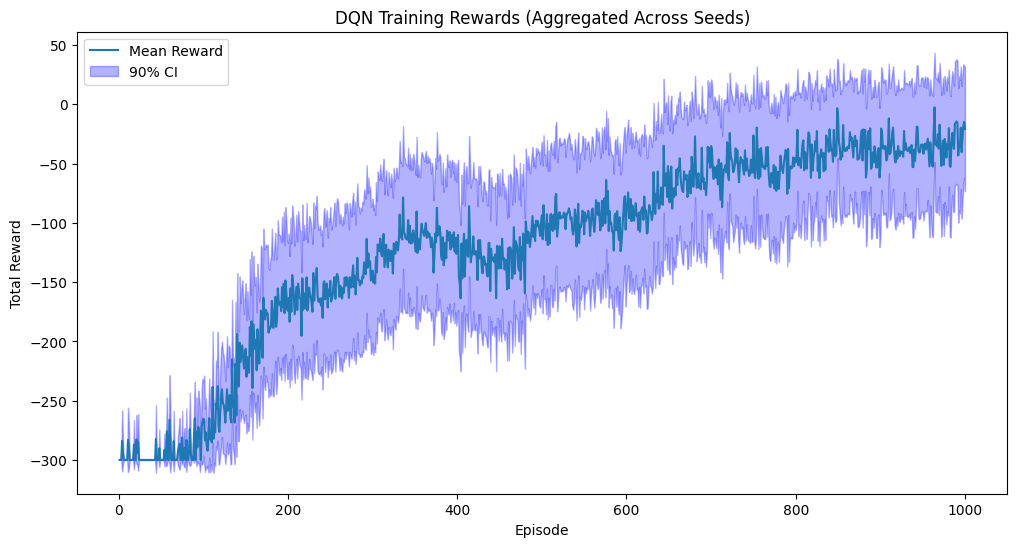

In [3]:
from tbu_gym.tbu_discrete import TruckBackerEnv_D
num_episodes = 1000
max_steps_per_episode = 500
learning_rate = 1e-3
epsilon_start = 0.5
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 5


seeds = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


import seaborn as sns
import matplotlib.pyplot as plt

all_rewards = []
for seed in seeds:
    print(f"\n========== RUN SEED = {seed} ==========\n")
    
    # Global RNGs
    set_global_seed(seed)

    # Environment
    env = TruckBackerEnv_D(render_mode=None)
    env.seed(seed)
    env.action_space.seed(seed)
    state = env.reset()

    # Agent
    agent = DQNAgent(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.n,
        lr=learning_rate,
        epsilon=epsilon_start,
        epsilon_decay=epsilon_decay,
        epsilon_min=epsilon_min,
        batch_size=batch_size,
        seed=seed
    )

    episode_rewards = []

    for episode in range(1, num_episodes + 1):
        env.seed(seed + episode)
        state = env.reset()
        total_reward = 0

        for t in range(max_steps_per_episode):
            action = agent.agent_policy(state)
            next_state, reward, done, info = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.train_with_mem()
            state = next_state
            total_reward += reward
            if done:
                break

        if episode % target_update_freq == 0:
            agent.update_target()

        episode_rewards.append(total_reward)
        print(f"Seed {seed} | Episode {episode} | Reward {total_reward:.2f}")

    # Store rewards for this seed
    all_rewards.append(episode_rewards)

# Convert to NumPy array for easier aggregation
all_rewards = np.array(all_rewards)  # shape = (num_seeds, num_episodes)
num_seeds = all_rewards.shape[0]

# Compute mean and standard deviation across seeds
mean_rewards = np.mean(all_rewards, axis=0)
std_rewards = np.std(all_rewards, axis=0)

# Compute 90% confidence interval
ci_multiplier = 1.645  # for 90% confidence
ci = ci_multiplier * (std_rewards / np.sqrt(num_seeds))

# Plot mean reward with 90% confidence interval
plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(1, num_episodes+1), y=mean_rewards, label="Mean Reward")
plt.fill_between(np.arange(1, num_episodes+1), mean_rewards - ci, mean_rewards + ci, alpha=0.3, color="blue", label="90% CI")
plt.title("DQN Training Rewards (Aggregated Across Seeds)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


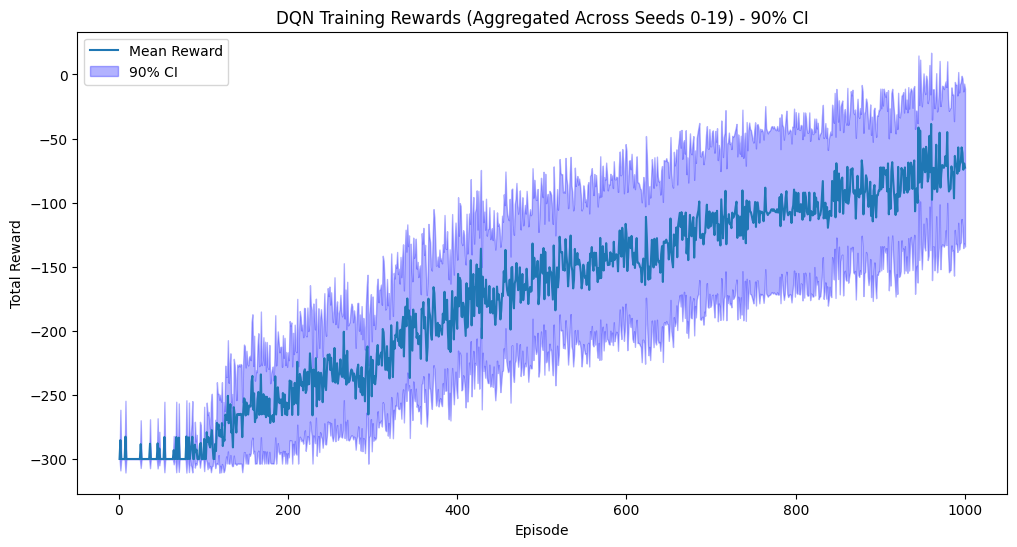

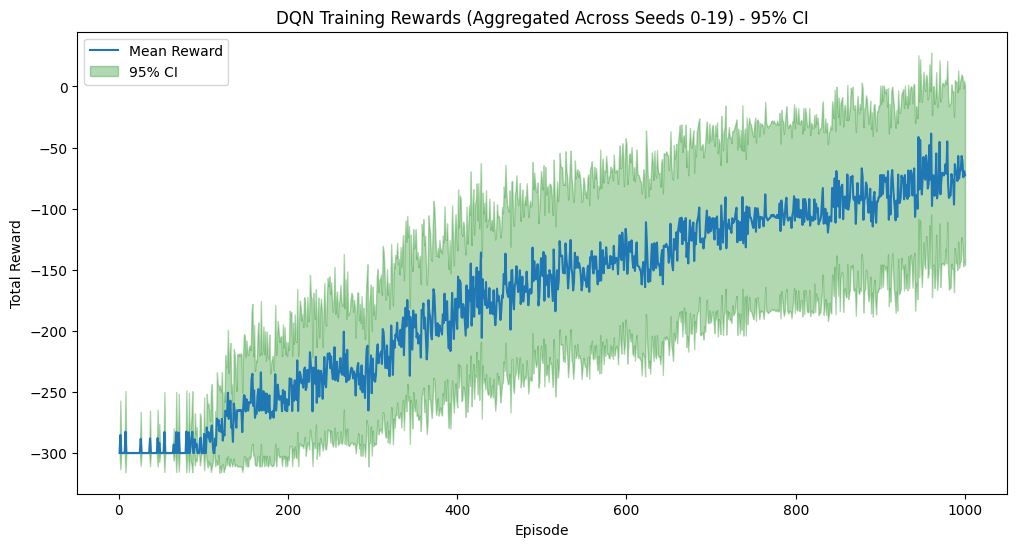

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# save the rewards so can be loaded later instead of re training
torch.save(
    {
        "rewards": torch.tensor(all_rewards, dtype=torch.float32),
    },
    r"C:\Users\otten\Desktop\CMPUT655-Project\data\dqn_all_rewards.pt"
)
all_rewards_subset = np.array(all_rewards[:20])  # shape = (20, num_episodes)
num_seeds = all_rewards_subset.shape[0]

# Compute mean and std across seeds
mean_rewards = np.mean(all_rewards_subset, axis=0)
std_rewards = np.std(all_rewards_subset, axis=0)

# 90% confidence interval
ci_90 = 1.645 * (std_rewards / np.sqrt(num_seeds))

plt.figure(figsize=(12,6))
sns.lineplot(x=np.arange(1, num_episodes+1), y=mean_rewards, label="Mean Reward")
plt.fill_between(np.arange(1, num_episodes+1), mean_rewards - ci_90, mean_rewards + ci_90,
                 alpha=0.3, color="blue", label="90% CI")
plt.title("DQN Training Rewards (Aggregated Across Seeds 0-19) - 90% CI")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

# 95% confidence interval
ci_95 = 1.96 * (std_rewards / np.sqrt(num_seeds))

plt.figure(figsize=(14, 6))

sns.lineplot(
    x=np.arange(1, len(episode_rewards) + 1),
    y=episode_rewards,
    label="QRC Episode Reward",
    color="red"
)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.grid(True)
plt.legend()
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')
plt.show()